In [1]:
import sys
sys.path.extend(['..'])

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import json
from pathlib import Path
from tqdm.auto import trange, tqdm
import stan
from random_f import LazyMixtureOfSinusoids, power_law

%matplotlib inline

In [3]:
root_dir = Path('..')

**Pick a model**

In [4]:
problem = 'lasso_regression'
results = torch.load(root_dir / problem / 'bias_variance_mse.dat')

In [5]:
alphas = np.linspace(results['args'].alpha_min, results['args'].alpha_max, results['args'].num_alpha)
lambdas = results['args'].lambdas.split(',')
t_history = results['t_history']
phase_history = results['phase_history']
freqs = torch.arange(results['args'].freq_min, results['args'].freq_max+1, dtype=torch.float32)
norm = vars(results['args']).get('power_law_norm', 'max')
f = LazyMixtureOfSinusoids(dim=t_history.shape[-1], freqs=freqs)

true_ev = results['true_ev']
nuts_ev = results['nuts_ev']
advi_ev = results['advi_ev']
isvi_ev = results['isvi_ev']

print("Loaded bias/variance results from", problem)

Loaded bias/variance results from arK


/Users/richard/Research/sampling-variational/stan-demos/notebooks/../random_f.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._omega = torch.tensor(freqs, device=device)


## Configure plotting

In [6]:
plot_alpha = -2.0
sel_i, sel_j = 0, np.argmin(np.abs(alphas - plot_alpha))
plot_T = 20

### Compute bias^2, variance, MSE, separately for each (f, alpha)

In [7]:
num_fs, num_alphas, num_subs = nuts_ev.shape

# advi_ev has dimensions (random fs, alphas, runs)
advi_bias2 = (torch.mean(advi_ev, dim=2) - true_ev)**2
advi_variance = torch.var(advi_ev, dim=2)
advi_mse = advi_bias2 + advi_variance
# nuts_ev has dimensions (random fs, alphas, subsamples)
nuts_bias2 = (torch.mean(nuts_ev, dim=2) - true_ev)**2
nuts_variance = torch.var(nuts_ev, dim=2) * results['args'].T / plot_T  # Variance goes like 1/T
nuts_mse = nuts_bias2 + nuts_variance
# isvi_ev has dimensions (random fs, alphas, subsamples, lambdas)
isvi_bias2 = (torch.mean(isvi_ev, dim=2) - true_ev[:,:,None])**2
isvi_variance = torch.var(isvi_ev, dim=2) * results['args'].T / plot_T  # Variance goes like 1/T
isvi_mse = isvi_bias2 + isvi_variance

Now compute mean and SEM across random f's

In [8]:
nuts_avg_bias2 = torch.mean(nuts_bias2, dim=0)
nuts_sem_bias2 = torch.std(nuts_bias2, dim=0) / np.sqrt(num_fs)
nuts_avg_variance = torch.mean(nuts_variance, dim=0)
nuts_sem_variance = torch.std(nuts_variance, dim=0) / np.sqrt(num_fs)
nuts_avg_mse = torch.mean(nuts_mse, dim=0)
nuts_sem_mse = torch.std(nuts_mse, dim=0) / np.sqrt(num_fs)

advi_avg_bias2 = torch.mean(advi_bias2, dim=0)
advi_sem_bias2 = torch.std(advi_bias2, dim=0) / np.sqrt(num_fs)
advi_avg_variance = torch.mean(advi_variance, dim=0)
advi_sem_variance = torch.std(advi_variance, dim=0) / np.sqrt(num_fs)
advi_avg_mse = torch.mean(advi_mse, dim=0)
advi_sem_mse = torch.std(advi_mse, dim=0) / np.sqrt(num_fs)

isvi_avg_bias2 = torch.mean(isvi_bias2, dim=0)
isvi_sem_bias2 = torch.std(isvi_bias2, dim=0) / np.sqrt(num_fs)
isvi_avg_variance = torch.mean(isvi_variance, dim=0)
isvi_sem_variance = torch.std(isvi_variance, dim=0) / np.sqrt(num_fs)
isvi_avg_mse = torch.mean(isvi_mse, dim=0)
isvi_sem_mse = torch.std(isvi_mse, dim=0) / np.sqrt(num_fs)

### Visualize f(x,y) (2d problems only)

In [9]:
if problem == 'banana' or problem == 'cigar':
    nuts_samples = pd.read_csv(root_dir / problem / 'nuts_1.csv', comment='#')
    nuts_samples = nuts_samples.sample(frac=1.) # shuffle rows

    if problem == 'banana':
        x, y = torch.linspace(-4,4,200), torch.linspace(-2,4,200)
    elif problem == 'cigar':
        x, y = torch.linspace(-4,4,200), torch.linspace(-4,4,200)
    xy = torch.stack(torch.meshgrid(x, y), dim=0).reshape(2, -1)
    f.set_t(t_history[sel_i]).update_table_x(xy)
    weights = power_law(freqs, alphas[sel_j], norm)
    plt.imshow(f.apply(weights, phase_history[sel_i]).reshape(len(y), len(x)),
               origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), cmap='Greys')
    if problem == 'banana':
        plt.plot(nuts_samples['x'][:500], nuts_samples['y'][:500], '.g', alpha=.4)
    elif problem == 'cigar':
        plt.plot(nuts_samples['x.2'][:500], nuts_samples['x.2'][:500], '.g', alpha=.4)
    plt.xlim([x.min(), x.max()])
    plt.ylim([y.min(), y.max()])
    plt.show()

### Plot expectation of f curve for a single f, alpha combination

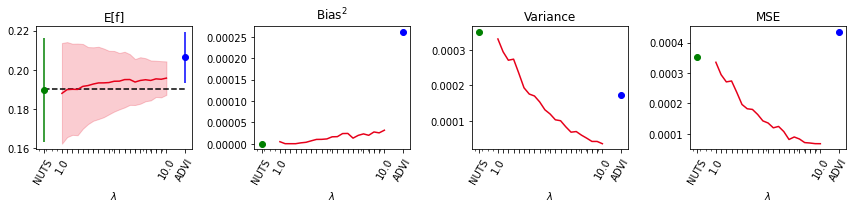

In [10]:
plot_lam = np.array([float(l) for l in lambdas])
x_nuts = plot_lam[0]*2/3
x_advi = plot_lam[-1]*3/2

nuts_mean = torch.mean(nuts_ev, dim=2)[sel_i,sel_j]
nuts_std = torch.std(nuts_ev, dim=2)[sel_i,sel_j]
advi_mean = torch.mean(advi_ev, dim=2)[sel_i,sel_j]
advi_std = torch.std(advi_ev, dim=2)[sel_i,sel_j]
isvi_mean = torch.squeeze(torch.mean(isvi_ev, dim=2))[sel_i,sel_j]
isvi_std = torch.squeeze(torch.std(isvi_ev, dim=2))[sel_i,sel_j]

isvi_color = (0.9,0.0,0.1)

fig, ax = plt.subplots(1, 4, figsize=(12,3))

# === EXPECTED F ===
# True value as horizontal black dashed line
ax[0].hlines(true_ev[sel_i,sel_j], x_nuts, x_advi, linestyle='--', color='k')
# NUTS point on the left
ax[0].errorbar(x_nuts, nuts_mean, yerr=nuts_std, color='g', marker='o')
# ADVI point on the right
ax[0].errorbar(x_advi, advi_mean, yerr=advi_std, color='b', marker='o')
# ISVI values in between
ax[0].fill_between(plot_lam, isvi_mean-isvi_std, isvi_mean+isvi_std, color=isvi_color+(0.2,))
ax[0].plot(plot_lam, isvi_mean, color=isvi_color)
ax[0].set_title('E[f]')

# === BIAS^2 ===
# NUTS point on the left
ax[1].plot(x_nuts, nuts_bias2[sel_i, sel_j], color='g', marker='o')
# ADVI point on the right
ax[1].plot(x_advi, advi_bias2[sel_i, sel_j], color='b', marker='o')
# ISVI values in between
ax[1].plot(plot_lam, isvi_bias2[sel_i, sel_j], color=isvi_color)
ax[1].set_title('Bias$^2$')

# === VARIANCE ===
# NUTS point on the left
ax[2].plot(x_nuts, nuts_variance[sel_i, sel_j], color='g', marker='o')
# ADVI point on the right
ax[2].plot(x_advi, advi_variance[sel_i, sel_j], color='b', marker='o')
# ISVI values in between
ax[2].plot(plot_lam, isvi_variance[sel_i, sel_j], color=isvi_color)
ax[2].set_title('Variance')


# === MSE ===
# NUTS point on the left
ax[3].plot(x_nuts, nuts_mse[sel_i, sel_j], color='g', marker='o')
# ADVI point on the right
ax[3].plot(x_advi, advi_mse[sel_i, sel_j], color='b', marker='o')
# ISVI values in between
ax[3].plot(plot_lam, isvi_mse[sel_i, sel_j], color=isvi_color)
ax[3].set_title('MSE')

# Axis formats and labels
for a in ax:
    a.set_xscale('log')
    a.set_xticks([x_nuts] + [l for l in plot_lam] + [x_advi])
    labs = a.get_xticklabels()
    labs[0] = 'NUTS'
    labs[1] = plot_lam[0]
    labs[-2] = plot_lam[-1]
    labs[-1] = 'ADVI'
    a.set_xticklabels(labs, rotation=60)
    a.set_xlabel('$\lambda$')

fig.tight_layout()

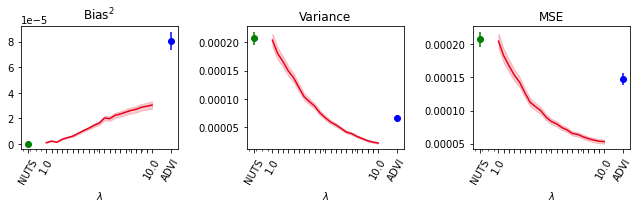

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(9,3))

# === BIAS^2 ===
# NUTS point on the left
ax[0].errorbar(x_nuts, nuts_avg_bias2[sel_j], yerr=nuts_sem_bias2[sel_j], color='g', marker='o')
# ADVI point on the right
ax[0].errorbar(x_advi, advi_avg_bias2[sel_j], yerr=advi_sem_bias2[sel_j], color='b', marker='o')
# ISVI values in between
ax[0].fill_between(plot_lam,
                   isvi_avg_bias2[sel_j] - isvi_sem_bias2[sel_j],
                   isvi_avg_bias2[sel_j] + isvi_sem_bias2[sel_j],
                   color=isvi_color+(0.2,))
ax[0].plot(plot_lam, isvi_avg_bias2[sel_j], color=isvi_color)
ax[0].set_title('Bias$^2$')

# === VARIANCE ===
# NUTS point on the left
ax[1].errorbar(x_nuts, nuts_avg_variance[sel_j], yerr=nuts_sem_variance[sel_j], color='g', marker='o')
# ADVI point on the right
ax[1].errorbar(x_advi, advi_avg_variance[sel_j], yerr=advi_sem_variance[sel_j], color='b', marker='o')
# ISVI values in between
ax[1].fill_between(plot_lam,
                   isvi_avg_variance[sel_j] - isvi_sem_variance[sel_j],
                   isvi_avg_variance[sel_j] + isvi_sem_variance[sel_j],
                   color=isvi_color+(0.2,))
ax[1].plot(plot_lam, isvi_avg_variance[sel_j], color=isvi_color)
ax[1].set_title('Variance')


# === MSE ===
# NUTS point on the left
ax[2].errorbar(x_nuts, nuts_avg_mse[sel_j], yerr=nuts_sem_mse[sel_j], color='g', marker='o')
# ADVI point on the right
ax[2].errorbar(x_advi, advi_avg_mse[sel_j], yerr=advi_sem_mse[sel_j], color='b', marker='o')
# ISVI values in between
ax[2].fill_between(plot_lam,
                   isvi_avg_mse[sel_j] - isvi_sem_mse[sel_j],
                   isvi_avg_mse[sel_j] + isvi_sem_mse[sel_j],
                   color=isvi_color+(0.2,))
ax[2].plot(plot_lam, isvi_avg_mse[sel_j], color=isvi_color)
ax[2].set_title('MSE')

# Axis formats and labels
for a in ax:
    a.set_xscale('log')
    a.set_xticks([x_nuts] + [l for l in plot_lam] + [x_advi])
    labs = a.get_xticklabels()
    labs[0] = 'NUTS'
    labs[1] = plot_lam[0]
    labs[-2] = plot_lam[-1]
    labs[-1] = 'ADVI'
    a.set_xticklabels(labs, rotation=60)
    a.set_xlabel('$\lambda$')

fig.tight_layout()

### MSE vs $\lambda$, illustrating dependence on $\alpha$

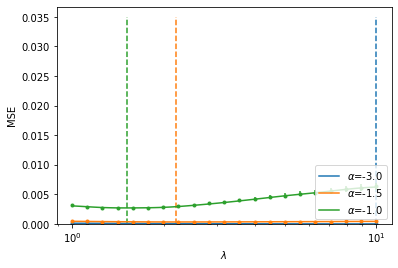

In [12]:
ll, aa = np.meshgrid(plot_lam, alphas)

def smooth(x, y, yerr, xi, tau=None):
    if tau is None:
        tau = np.mean(np.abs(np.diff(x)))
    pair_diff2 = (x.flatten()[:,None] - xi.flatten()[None,:])**2 / tau**2
    weights = 1/(yerr.flatten()[:,None]**2) * np.exp(-pair_diff2/2)
    weights = weights / torch.sum(weights, dim=0, keepdim=True)
#     plt.figure();plt.imshow(weights)
    return y.float() @ weights.float()
    

plot_alpha = [-3, -1.5, -1]
smooth_lambda = np.logspace(0, 1, 100)
idx_alpha = [np.argmin(np.abs(alphas - a)) for a in plot_alpha]
for ia, a in zip(idx_alpha, plot_alpha):
    smooth_mse = smooth(np.log(plot_lam), y=isvi_avg_mse[ia], yerr=isvi_sem_mse[ia], xi=np.log(smooth_lambda))
    h, = plt.plot(smooth_lambda, smooth_mse, label=r'$\alpha$='+f'{a:.1f}')
    plt.errorbar(x=plot_lam, y=isvi_avg_mse[ia], yerr=isvi_sem_mse[ia],
                 color=h.get_color(), linestyle='', marker='.')
    best_lam = smooth_lambda[np.argmin(smooth_mse)]
    plt.vlines(best_lam, 0, .035, color=h.get_color(), linestyle='--')
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.ylim([0,None])
plt.show()

### Surfaces

/var/folders/ph/lx9dyyx91893rxnlw09n7t0c0000gn/T/ipykernel_77672/1170169794.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
/var/folders/ph/lx9dyyx91893rxnlw09n7t0c0000gn/T/ipykernel_77672/1170169794.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


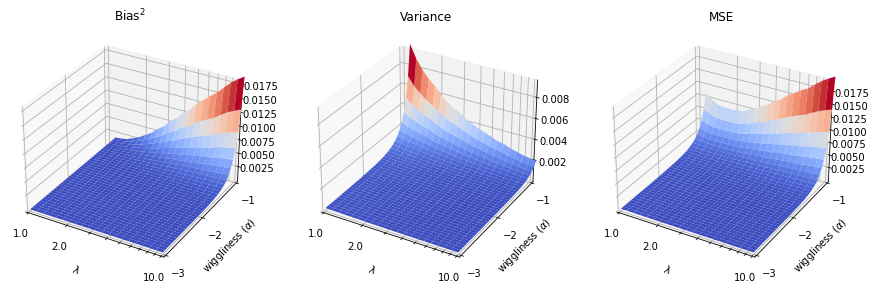

In [13]:
from matplotlib import cm

ll, aa = np.meshgrid(plot_lam, alphas)

idx_l = (plot_lam >= 1.0) & (plot_lam <= 10.0)
idx_a = (alphas >= -3.0) & (alphas <= -0.75)

fig = plt.figure(figsize=(15, 5))
ax = [fig.add_subplot(131, projection='3d'), fig.add_subplot(132, projection='3d'), fig.add_subplot(133, projection='3d')]

ax[0].plot_surface(np.log10(ll[:,idx_l][idx_a,:]), aa[:,idx_l][idx_a,:], isvi_avg_bias2[:,idx_l][idx_a,:].numpy(), cmap=cm.coolwarm)
ax[0].set_title(r'Bias$^2$')
ax[1].plot_surface(np.log10(ll[:,idx_l][idx_a,:]), aa[:,idx_l][idx_a,:], isvi_avg_variance[:,idx_l][idx_a,:].numpy(), cmap=cm.coolwarm)
ax[1].set_title(r'Variance')
ax[2].plot_surface(np.log10(ll[:,idx_l][idx_a,:]), aa[:,idx_l][idx_a,:], isvi_avg_mse[:,idx_l][idx_a,:].numpy(), cmap=cm.coolwarm)
ax[2].set_title(r'MSE')

for a in ax:
#     a.set_zlim([0, .04])
#     a.set_zticks(np.linspace(0,.04,5))

    a.set_ylim([-3, -1])
    a.set_yticks([-3, -2, -1])
    a.set_ylabel(r'wiggliness ($\alpha$)')

    a.set_xlim([0, 1])
    a.set_xticks(np.log10(np.linspace(1,10,10)))
    a.set_xticklabels(['1.0', '2.0'] + ['']*7 + ['10.0'])
    a.set_xlabel(r'$\lambda$')
    # a.azim=-120

    fig.tight_layout()